In [4]:
from importlib import reload
import sys
import os
sys.path.append(os.path.abspath('../'))
import util
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
reload(util)

<module 'util' from 'c:\\Users\\fujos\\Github\\Prosperity-3\\Testing\\util.py'>

In [3]:
prices = util.load_all_price_data(1).iloc[:60000]
squid_vwap = util.get_vwap(prices, 'SQUID_INK')
log_ret = np.log(squid_vwap).diff().dropna()

0.766577491388535


<Axes: ylabel='Count'>

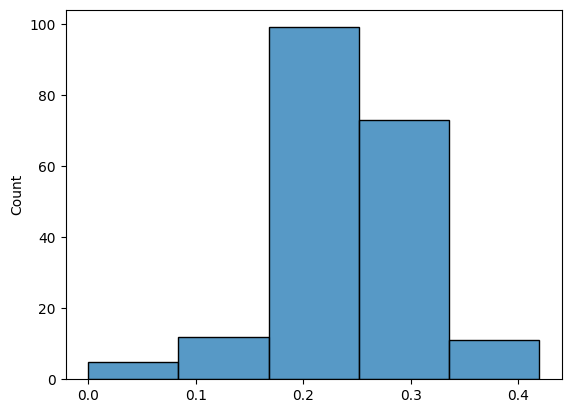

In [101]:
from scipy.stats import norm

def pco(squid_vwap, short_lookback=10, multiplier = 4):
    log_ret = abs(np.log(squid_vwap).diff()).dropna()
    raw_pco = log_ret.rolling(short_lookback).mean()-log_ret.rolling(short_lookback*multiplier).mean()
    C = 0.36+1/short_lookback + 0.7*np.log(0.5*multiplier)/1.609
    ATR = 3
    pco = raw_pco/(C*ATR)
    def windsorize_series(series, lower_quantile=0.01, upper_quantile=0.99):
        lower = series.quantile(lower_quantile)
        upper = series.quantile(upper_quantile)
        return series.clip(lower=lower, upper=upper)
    pco = windsorize_series(pco, lower_quantile=0.005, upper_quantile=0.995)
    return pd.Series(norm.cdf(4*pco.dropna()))
def macd(squid_vwap, short_lookback=10, long_lookback=20):
    """
    Compute the cumulative moving average of the squid vwap.
    """
    raw_macd = squid_vwap.ewm(span=short_lookback, adjust=False).mean() - squid_vwap.ewm(span=long_lookback, adjust=False).mean()
    distance = (long_lookback-1)/2
    distance -= (short_lookback-1)/2
    norm = 3*np.sqrt(distance)
    def sigmoid(x):
        return 1/(1 + np.exp(-x))
    norm_macd = sigmoid(1.5*raw_macd/norm)
    return norm_macd
def cmma(squid_vwap, lookback=10):
    """
    Compute the cumulative moving average of the squid vwap.
    """
    raw_cmma = (squid_vwap - squid_vwap.rolling(lookback).mean().shift(1)).divide(np.sqrt(lookback+1)).dropna()
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    return sigmoid(raw_cmma) 
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())
squid_pco = pco(squid_vwap, short_lookback=5, multiplier = 2)
squid_macd = macd(squid_vwap, short_lookback=5, long_lookback=20)
squid_cmma = cmma(squid_vwap, lookback=10)
squid_pco = normalize(squid_pco)*normalize(squid_macd)
p = print
p(util.relative_entropy_binned(squid_pco.dropna(), 10))
sns.histplot(squid_pco, bins=5)

<Axes: >

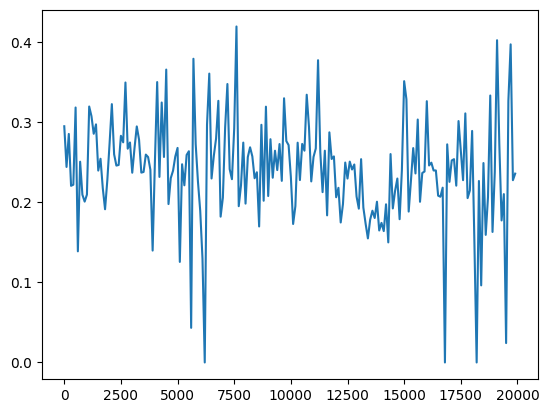

In [102]:
squid_pco.dropna().plot()

In [103]:
def get_portfolio(signal_series, long_threshold, short_threshold):
    """
    Get portfolio based on signal series.
    """
    portfolio = pd.Series(index=signal_series.index, dtype=float)
    portfolio[signal_series > long_threshold] = 1  # Long position
    portfolio[signal_series < short_threshold] = -1  # Short position
    portfolio.fillna(0, inplace=True)  # No position
    return portfolio
def get_returns(returns, portfolio, tc = 1.5/2000, lookforward = 1):
    """
    Get returns based on portfolio.
    """
    returns = returns.rolling(lookforward).sum()
    to = abs(portfolio.diff())
    portfolio_returns = portfolio.shift(lookforward) * returns- to * tc
    return portfolio_returns.dropna()

In [104]:
def get_performance_table(signal, returns):
    thresholds = np.linspace(0.01, 0.99, 49)
    sigmax, sigmin = signal.max(), signal.min()
    performance_data = []
    
    for threshold_frac in thresholds:
        threshold = np.quantile(signal, threshold_frac)
        buy_portfolio = get_portfolio(signal, threshold, sigmin)
        buy_returns = get_returns(returns, buy_portfolio)
        buy_cum_returns = (buy_returns).sum()
        sell_portfolio = -get_portfolio(signal, threshold, sigmin)
        sell_returns = get_returns(returns, sell_portfolio)
        sell_cum_returns = (sell_returns).sum()

        sellless_portfolio = get_portfolio(signal, sigmax, threshold)
        sellless_returns = get_returns(returns, sellless_portfolio)
        sellless_cum_returns = (sellless_returns).sum()
        buyless_portfolio = -get_portfolio(signal, sigmax, threshold)
        buyless_returns = get_returns(returns, buyless_portfolio)   
        buyless_cum_returns = (buyless_returns).sum()

        performance_data.append({
            'Threshold': threshold,
            'FracGreater': 1-threshold_frac,
            'LongTotRet': buy_cum_returns,
            'ShortTotRet': sell_cum_returns,
            'FracLess': threshold_frac,
            'Long2TotRet': buyless_cum_returns,
            'Short2TotRet': sellless_cum_returns
        })
    performance_df = pd.DataFrame(performance_data)
    return performance_df
pco_performance = round(get_performance_table(squid_pco.dropna(), log_ret),2)
pco_performance

,Threshold,FracGreater,LongTotRet,ShortTotRet,FracLess,Long2TotRet,Short2TotRet
0,0.00,0.99,-0.01,-0.00,0.01,0.00,0.00
1,0.13,0.97,-0.01,-0.01,0.03,-0.01,-0.01
2,0.15,0.95,-0.02,-0.01,0.05,-0.01,-0.02
3,0.16,0.93,-0.02,-0.01,0.07,-0.02,-0.02
4,0.17,0.91,-0.03,-0.02,0.09,-0.02,-0.03
5,0.18,0.89,-0.03,-0.02,0.11,-0.02,-0.03
6,0.18,0.87,-0.04,-0.03,0.13,-0.03,-0.03
7,0.19,0.85,-0.04,-0.03,0.15,-0.03,-0.04
8,0.19,0.83,-0.04,-0.03,0.17,-0.04,-0.04
9,0.20,0.81,-0.04,-0.04,0.19,-0.04,-0.04
